In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Define the model
latent_dim = 10
beta = 4
lambda_cov = 0.01

# Define the encoder
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)
z = keras.layers.Lambda(lambda t: t[0] + tf.exp(0.5 * t[1]) * tf.random.normal(tf.shape(t[1])))([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Define the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = keras.layers.Reshape((7, 7, 128))(x)
x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, outputs, name="decoder")
def covariance_loss(z_mean, z_logvar):
    # Compute the covariance matrix
    cov = tf.exp(z_logvar)
    cov = tf.linalg.diag(cov)
    
    # Compute the mean of the latent variables
    mean = tf.reduce_mean(z_mean, axis=0, keepdims=True)
    
    # Compute the covariance of the latent variables
    centered = z_mean - mean
    cov_latent = tf.matmul(centered, centered, transpose_a=True)
    cov_latent /= tf.cast(tf.shape(z_mean)[0] - 1, dtype=tf.float32)
    
    # Compute the Frobenius norm of the difference between the covariance matrices
    norm = tf.norm(cov - cov_latent, ord="fro",axis=(1,2))
    
    # Return the loss
    return norm
# Define the VAE model with the beta-VAE and covariance loss terms
class BetaCovarianceVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, lambda_cov, **kwargs):
        super(BetaCovarianceVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.lambda_cov = lambda_cov

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def compute_loss(self, x):
        # z_mean, z_log_var, z = self.encoder(x)
        # reconstruction = self.decoder(z)

        # # Compute the covariance matrix
        # cov = tf.exp(z_log_var)
        # cov = tf.linalg.diag(cov)

        # # Compute the reconstruction loss
        # reconstruction_loss = keras.losses.binary_crossentropy(x, reconstruction)
        # # reconstruction_loss = keras.backend.mean(reconstruction_loss)

        # # Compute the KL divergence loss
        # kl_loss = -0.5 * keras.backend.mean(1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var))

        # # Compute the covariance loss
        # # z_mean_centered = z_mean - keras.backend.mean(z_mean, axis=0, keepdims=True)
        # # # Compute the covariance of the latent variables
        # # centered = z_mean - z_mean_centered
        # # cov_latent = tf.matmul(centered, centered, transpose_a=True)
        # # cov_latent /= tf.cast(tf.shape(z_mean)[0] - 1, dtype=tf.float32)
        
        # # # Compute the Frobenius norm of the difference between the covariance matrices
        # # norm = tf.norm(cov - cov_latent, ord="fro",axis=(0,1))
        
        # # # Return the loss
        # # return norm
        # kl_loss = tf.reduce_sum(kl_loss, axis=1)

        # # Covariance loss
        # cov_loss = covariance_loss(z_mean, z_log_var)

        # # Total loss
        # loss = tf.reduce_mean(recon_loss + self.beta * kl_loss + self.lambda_cov * cov_loss)
        # return loss

        z_mean, z_logvar, z = self.encoder(x)
        x_mean = self.decoder(z)

        # Reconstruction loss
        recon_loss = keras.losses.binary_crossentropy(x, x_mean)
        recon_loss = tf.reduce_sum(recon_loss, axis=[1, 2])
        # print(recon_loss)

        # KL divergence loss
        kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        # print(kl_loss)

        # Covariance loss
        cov_loss = covariance_loss(z_mean, z_logvar)
        # print(cov_loss)

        # Total loss
        loss = tf.reduce_mean(recon_loss + self.beta * kl_loss + self.lambda_cov * cov_loss)
        return loss


Epoch 1, loss=312.9238, val_loss=280.4457
1/1 [==============================] - 0s 173ms/step


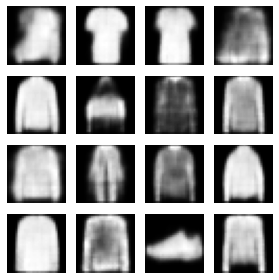

Epoch 2, loss=276.4100, val_loss=276.1546
1/1 [==============================] - 0s 19ms/step


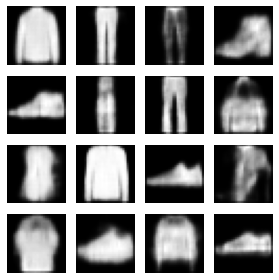

Epoch 3, loss=273.6512, val_loss=274.6395
1/1 [==============================] - 0s 17ms/step


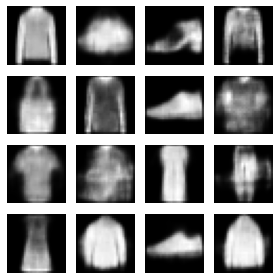

Epoch 4, loss=272.2608, val_loss=273.1417
1/1 [==============================] - 0s 18ms/step


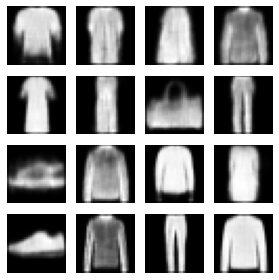

Epoch 5, loss=271.2571, val_loss=272.3470
1/1 [==============================] - 0s 31ms/step


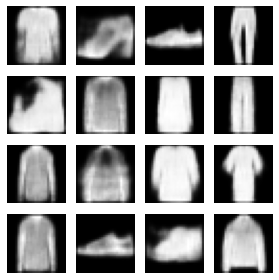

Epoch 6, loss=270.5676, val_loss=271.8313
1/1 [==============================] - 0s 19ms/step


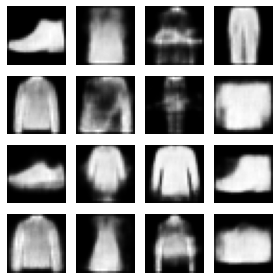

Epoch 7, loss=270.0916, val_loss=271.4255
1/1 [==============================] - 0s 19ms/step


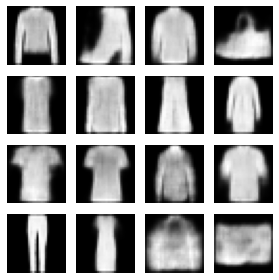

Epoch 8, loss=269.5931, val_loss=270.6979
1/1 [==============================] - 0s 18ms/step


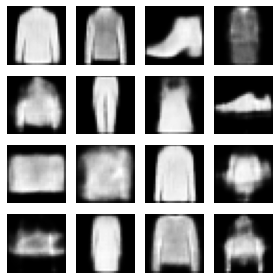

Epoch 9, loss=269.2036, val_loss=270.6107
1/1 [==============================] - 0s 18ms/step


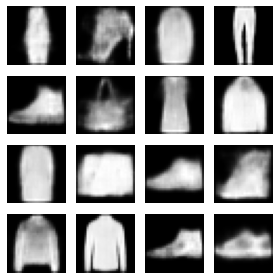

Epoch 10, loss=268.9729, val_loss=270.5183
1/1 [==============================] - 0s 18ms/step


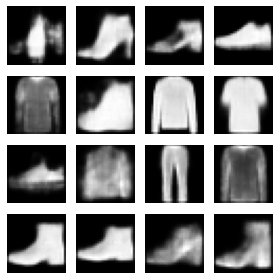

Epoch 11, loss=268.6654, val_loss=270.3150
1/1 [==============================] - 0s 19ms/step


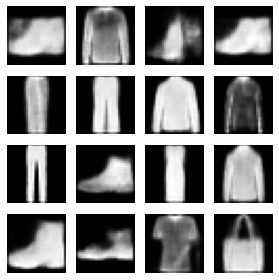

Epoch 12, loss=268.3792, val_loss=269.9037
1/1 [==============================] - 0s 19ms/step


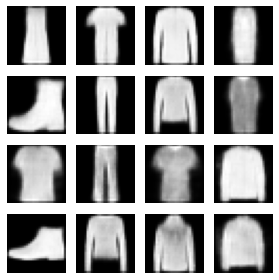

Epoch 13, loss=268.2169, val_loss=270.0752
1/1 [==============================] - 0s 19ms/step


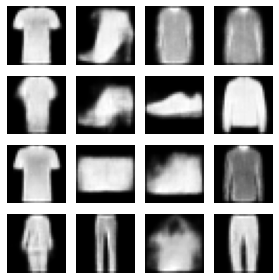

Epoch 14, loss=268.0280, val_loss=269.5476
1/1 [==============================] - 0s 17ms/step


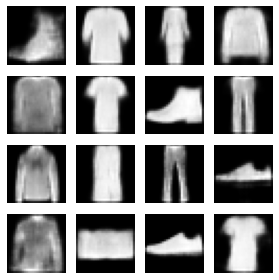

Epoch 15, loss=267.8194, val_loss=269.5510
1/1 [==============================] - 0s 19ms/step


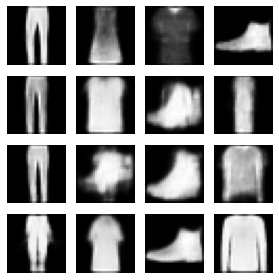

Epoch 16, loss=267.7495, val_loss=269.6327
1/1 [==============================] - 0s 31ms/step


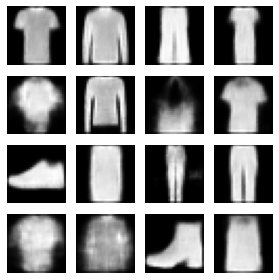

Epoch 17, loss=267.5193, val_loss=269.4259
1/1 [==============================] - 0s 19ms/step


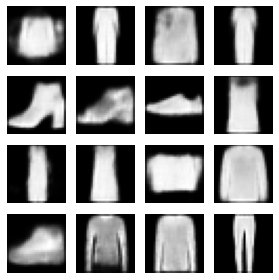

Epoch 18, loss=267.3723, val_loss=268.9338
1/1 [==============================] - 0s 19ms/step


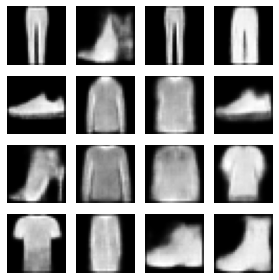

Epoch 19, loss=267.2268, val_loss=269.1057
1/1 [==============================] - 0s 20ms/step


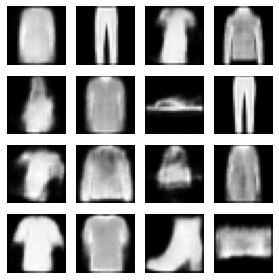

Epoch 20, loss=267.1299, val_loss=268.7821
1/1 [==============================] - 0s 18ms/step


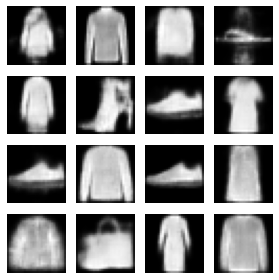

In [ ]:
# Create the beta-covariance VAE model
vae = BetaCovarianceVAE(encoder, decoder, beta, lambda_cov)

# Define the optimizer
optimizer = keras.optimizers.Adam(lr=0.001)

# Define the training loop
epochs = 20
batch_size = 128
num_batches = x_train.shape[0] // batch_size

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for i in range(num_batches):
        # Sample a batch of data
        batch_x = x_train[i * batch_size:(i + 1) * batch_size]

        # Compute the loss and gradients
        with tf.GradientTape() as tape:
            loss = vae.compute_loss(batch_x)
            grads = tape.gradient(loss, vae.trainable_weights)

        # Apply the gradients
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        epoch_loss += loss.numpy()

    # Compute the test loss
    test_loss = vae.compute_loss(x_test).numpy()

    # Print the losses
    print("Epoch {}, loss={:.4f}, val_loss={:.4f}".format(epoch, epoch_loss / num_batches, test_loss))

    # Generate some samples from the model
    z_sample = np.random.normal(size=(16, latent_dim))
    x_sample = decoder.predict(z_sample)
    x_sample = np.squeeze(x_sample, axis=-1)
    plt.figure(figsize=(4, 4))
    for j in range(16):
        plt.subplot(4, 4, j + 1)
        plt.imshow(x_sample[j], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 41ms/step


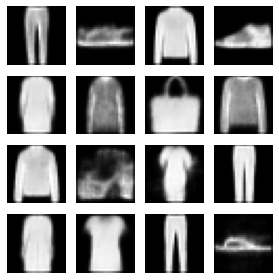

In [ ]:
z_sample = np.random.normal(size=(16, latent_dim))
x_sample = decoder.predict(z_sample)
x_sample = np.squeeze(x_sample, axis=-1)
plt.figure(figsize=(4, 4))
for j in range(16):
    plt.subplot(4, 4, j + 1)
    plt.imshow(x_sample[j], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
z_sample = [[0,
            1,
            0,
            1,
            -1,
            0.5,
            0,
            -0.5,
            0,
            0]]

1/1 [==============================] - 0s 20ms/step


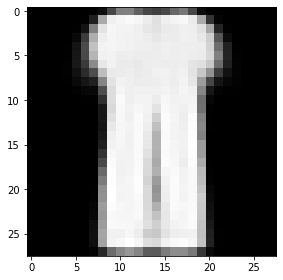

In [ ]:
z_sample = np.random.normal(size=(1,latent_dim))
x_sample = decoder.predict((z_sample))
x_sample = np.squeeze(x_sample)

plt.imshow(x_sample, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data you used to train the autoencoder
# X_train = x_train

# Load the trained autoencoder model
# autoencoder = ...

# Encode the training data
z_mean, z_logvar, z  = encoder.predict(x_train)

# Plot the latent space
# plt.scatter(latent_space[:, 0], latent_space[:, 1], c=np.argmax(y_train, axis=1))
# plt.colorbar()
# plt.show()


1875/1875 [==============================] - 5s 2ms/step


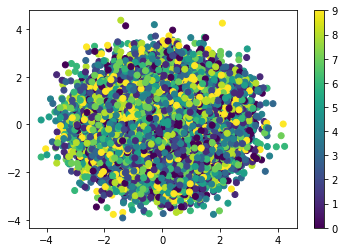

In [ ]:
plt.scatter(z[:, 0], z[:, 1], c=y_train)
plt.colorbar()
plt.show()

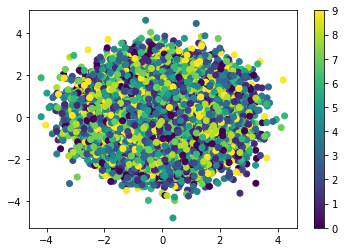

In [ ]:
plt.scatter(z[:, 0], z[:, 2], c=y_train)
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(z[:, 0], z[:, 2], c=y_train)
plt.colorbar()
plt.show()

In [ ]:
def inference(class_val, num_examples):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.
    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in x_train,y_train:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
  
        mu, sigma, _ = encoder.predict(images[d])
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[class_val]
    fig, axis = plt.subplots(1, 10, figsize = (50, 50))
    for example in range(num_examples):
        epsilon = tf.random(sigma)
        z = mu + sigma * epsilon
        # print(z)
        z[0][example] += 10
        out = decoder.predict(z)
        # out = out.view(-1, 1, 28, 28)
        # save_image(out, f"generated_{class_val}_ex{example}.png")
        out = tf.squeeze(out)
        axis[example].imshow(out.to('cpu').detach().numpy(), cmap = 'gray')
    plt.show()

for idx in range(3):
    inference(idx, num_examples=10)